In [2]:
#
# This notebook implements the mechanism responsible for regulating Cdc13-associated kinase activity in fission yeast
# in reference to Figure 1 and Table 1 presented in (Sveiczer, Csikasz-Nagy, Gyorffy, Tyson, and Novak, PNAS, 2000)
#
# The principles of biochemical kinetics are used to convert the molecular mechanism into
# a set of differential equiations that enable the numerical simulation of cell cycles
# in wild type (WT) and mutant cells 
#
# Hence, this model demonstrates the utility of mathematical modeling in enhancing the understanding 
# of fission yeast cell cycle
#

In [8]:
%matplotlib inline
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams['pdf.fonttype'] = 42

# seabornの設定
sns.set_style("ticks")
sns.set_context("paper")
sns.set_palette("husl")
fontSize = 18
sns.set(font_scale=1.5, style='ticks', rc={"lines.linewidth": 4, 'lines.markersize': 12})

In [3]:
#
# Regulation of Cdc13/Cdc2 kinase activity by positive and negative feedback loops determines
# the progression of fission yeast mitotic cycle through the G1, S, G2, and M phase. 
# Inactivation of the negative regulators - Rum1, Ste9, and Wee1/Mik 1 - and 
# activation of the positive regulator Cdc25 creates the positive feedback, 
# causing the increase in Cdc13/Cdc2 activity. 
# In contrast, the relatively slower negative feedback loop is induced during mitosis through the
# activation of Slp1/anaphase-promoting comple(APC), which subsequently re-activates the negative regulators. 
#
# The quantized cycle times in wee1- and cdc25Δ mutant cells in comparison to WT cells were observed to formulate
# numerical solutions that present the concentrations of the individual cell cycle regulators as functions of time.
# 
#
# Differential equations that model the mechanism for fission yeast cell cycle 
def cell_cycle(x, time):
    
    # ==============================================
    # Parameter definition 
    # Rate constants (dimensions of WT cells: min^-1)
    k5 = 0.1
    k_6 = 0.1
    k6 = 5
    kp = 100
    k_pp = 1
    kpp = 100
    kJ = 400
    kJR = 1
    k1 = 0.02 
    kSte9 = 5
    k_Ste9R = 0.03
    kSte9R = 8
    kM = 1
    k_MR = 0.01
    kMR = 5
    kW = 2
    k_WR = 0.4
    kWR = 1
    k25 = 1
    k_25R = 0.4
    k25R = 2
    kas = 0.1
    kad = 0.1
    k_aa = 0.01
    kaa = 0.1
    kai = 0.1
    k3 = 0.1
    ki = 50
    kiR = 0.5

    V_2 = 0.02
    V2 = 1
    V_2c = 0.02
    V2c = 0.5
    VWee = 10
    V_Wee = 0.08
    VMik = 2
    V_Mik = 0.04
    V25 = 10
    V_25 = 0.05
    VPyp = 0.07 
    V_4 = 0.01
    V4 = 1
    μ = 0.00462 
    #
    #Michaelis and other constants (dimensionless)
    JSte9 = 0.01
    JSte9R = 0.01
    JMik = 0.15
    JMikR = 0.15
    JWee = 0.2
    JWeeR = 0.2
    J25 = 0.05
    J25R = 0.05
    SK = 0.018
    ε = 0.05
    εp = 0.025
    K = 0.06
    Y = 0
    Pyp3 = 1 
    
    
    # ==============================================
    # Species
#     f = np.zeros((16,))
    Rum1 = x[0]
    Rum1P = x[1]
    CR = x[2]
    CRP = x[3]
    MPF = x[4]
    preMPF = x[5]
    Ste9 = x[6]
    Mik1 = x[7]
    Wee1 = x[8]
    Cdc25 = x[9]
    Slp1 = x[10]
    Slp1a = x[11]
    lnh = x[12]
    PI = x[13]
    mass = x[14]
    RDNA = x[15]
    kS = x[16]
    Y = x[17]
    
    # Rate functions 
    k2 = V_2 + V2* Ste9
    k2C = V_2c + V2c* Ste9
    kWee = VWee * Wee1 + V_Wee * (1 - Wee1) + VMik * Mik1 + V_Mik * (1 - Mik1)
    kC25 = V25 * Cdc25 + V_25 * (1 - Cdc25) + VPyp * Pyp3
    k4 = V_4 + V4 * Slp1a 
#     
    # Auxiliary functions # compares preMPF and MPF activities 
    MPFa = MPF + ε * preMPF
    PP = 1 - PI
    
#     if MPFa > 0.2:
#         Y = 100
#     else:
#         Y = 0

    f = np.zeros((18,))
    f[0] = k5 - k_6 * Rum1 - kp * (MPFa + εp * SK * mass) * Rum1 + (k_pp + kpp * PP)* Rum1P - kJ * MPF * Rum1 + kJR * CR + k2C * CR 
    f[1] = kp * (MPFa + εp * SK * mass) * Rum1 - (k_pp + kpp * PP) * Rum1P - (k_6 + k6) * Rum1P - kJ * MPF * Rum1P + kJR * CRP + k2C * CRP
    f[2] = kJ * MPF * Rum1 - kJR * CR - k2C * CR - k_6 * CR - kp * (MPFa + εp * SK * mass)*CR + (k_pp + kpp*PP) * CRP
    f[3] = kp * (MPFa + εp*SK*mass) * CR - (k_pp + kpp * PP)* CRP + kJ * MPF * Rum1P - kJR * CRP  - k2C * CRP - (k_6 + k6)*CRP
    # MPF
    f[4] = k1 * mass - k2 * MPF - kWee * MPF + kC25*preMPF - kJ * MPF * (Rum1 + Rum1P) + kJR * (CR + CRP)+ k_6 * CR + (k_6 + k6)*CRP
    # preMPF
    f[5] = kWee * MPF - kC25 * preMPF - k2 * preMPF
    f[6] = (k_Ste9R + kSte9R * PP)*((1-Ste9)/(JSte9R + 1 - Ste9))- kSte9 * (MPFa + SK * mass) * (Ste9/(JSte9+Ste9))
    f[7] = (kS + k_MR + kMR*PP)*((1-Mik1)/(JMikR + 1 - Mik1))- kM * MPFa * ((Mik1)/(JMik + Mik1))
    f[8] = (k_WR + kWR * PP)*((1-Wee1)/(JWeeR +1-Wee1)) - kW * MPFa * (Wee1/(JWee + Wee1))
    f[9] = k25 * MPFa * ((1-Cdc25)/(J25+1-Cdc25))- (kS + k_25R + k25R * PP)*(Cdc25/(J25R + Cdc25))
    f[10] = kas * MPFa - kad * Slp1
    f[11] = (k_aa + kaa*MPFa)*(Slp1-Slp1a)-kai * Slp1a - kad * Slp1a
    #Inf
    f[12] = k3 - ki * lnh * PP + kiR * PI - k4 * lnh
    #PI
    f[13] = ki * lnh * PP - kiR * PI - k4* PI
    f[14] = μ * mass
    # Replicated DNA
    f[15] = K/(1+Y*MPFa)
    # kS
    f[16] = 0
    # Y
    f[17] = 0
    
#
    return f

In [4]:
#
# Numerical integration

kS_max = 5
kS_min = 0.1
    
# time condition
startTime = 0 
endTime = 1800 # min
step = 1

# time points
time_points = np.linspace(startTime,endTime,int(endTime/step+1))
time_points_for_ODE = np.linspace(0, step, 2) #defining timepoints for ode solver
# print(time_points)

speciesN = 18

# data matrix
xvec = np.zeros((int(endTime/step+1),speciesN))

# initial values
c = 0.01
xinit = [c]*speciesN
xinit[0] = 0 # Rum1
xinit[4] = 2 # MPF
xinit[5] = 1 # preMPF
xinit[6] = 1 # ste9
xinit[7] = 0.8 # Mik1
xinit[8]= 1 # Wee1
xinit[9] = 0.9 # cdc25
xinit[13] = 0.6 # PI
xinit[14] = 1 # mass
xinit[16] = kS_min # kS

# input initial values in xvec at t = 0
xvec[0,:] = xinit

# MPFa = MPF + e*preMPF
epsi = 0.05

for i in range(int(endTime/step+1)-1):
#     print(i)
    xvec_temp = integrate.odeint(cell_cycle, xvec[i,:], time_points_for_ODE)
    xvec[i+1,:] = xvec_temp[1]
    
    # MPFa/PP
    MPFa_PP = (xvec[i+1,4]+epsi*xvec[i+1,5])/(1-xvec[i+1,13])
    # MPFa/PP t-1
    MPFa_PP_1 = (xvec[i,4]+epsi*xvec[i,5])/(1-xvec[i,13])
    
    if (MPFa_PP > 0.65) and (MPFa_PP_1 <= 0.65): # When the ratio MPFa!PP crosses 0.65 from below, S phase is initiated
        # RDNA = 0
        xvec[i+1,15] = 0
        # kS = kS_max
        xvec[i+1,16] = kS_max
        
    if (xvec[i+1,15] > 1): # if RDNA reaches 1, then DNA replication is complete, and kS is set to kS,min.
        # kS = kS_min
        xvec[i+1,16] = kS_min
        
    if (MPFa_PP < 0.5) and (MPFa_PP_1 >= 0.5): # When MPFa!PP crosses 0.5 from above, the cell divides functionally (mass 3 mass!2),
        # mass = mass/2
        xvec[i+1,14] = xvec[i+1,14]/2
        
    if (xvec[i+1,4]+epsi*xvec[i+1,5] >= 0.2): # When MPFa excees 0.2, Y = 100 (mass 3 mass!2),
        # mass = mass/2
        xvec[i+1,17] = 100
    else:
        xvec[i+1,17] = 0

    
    

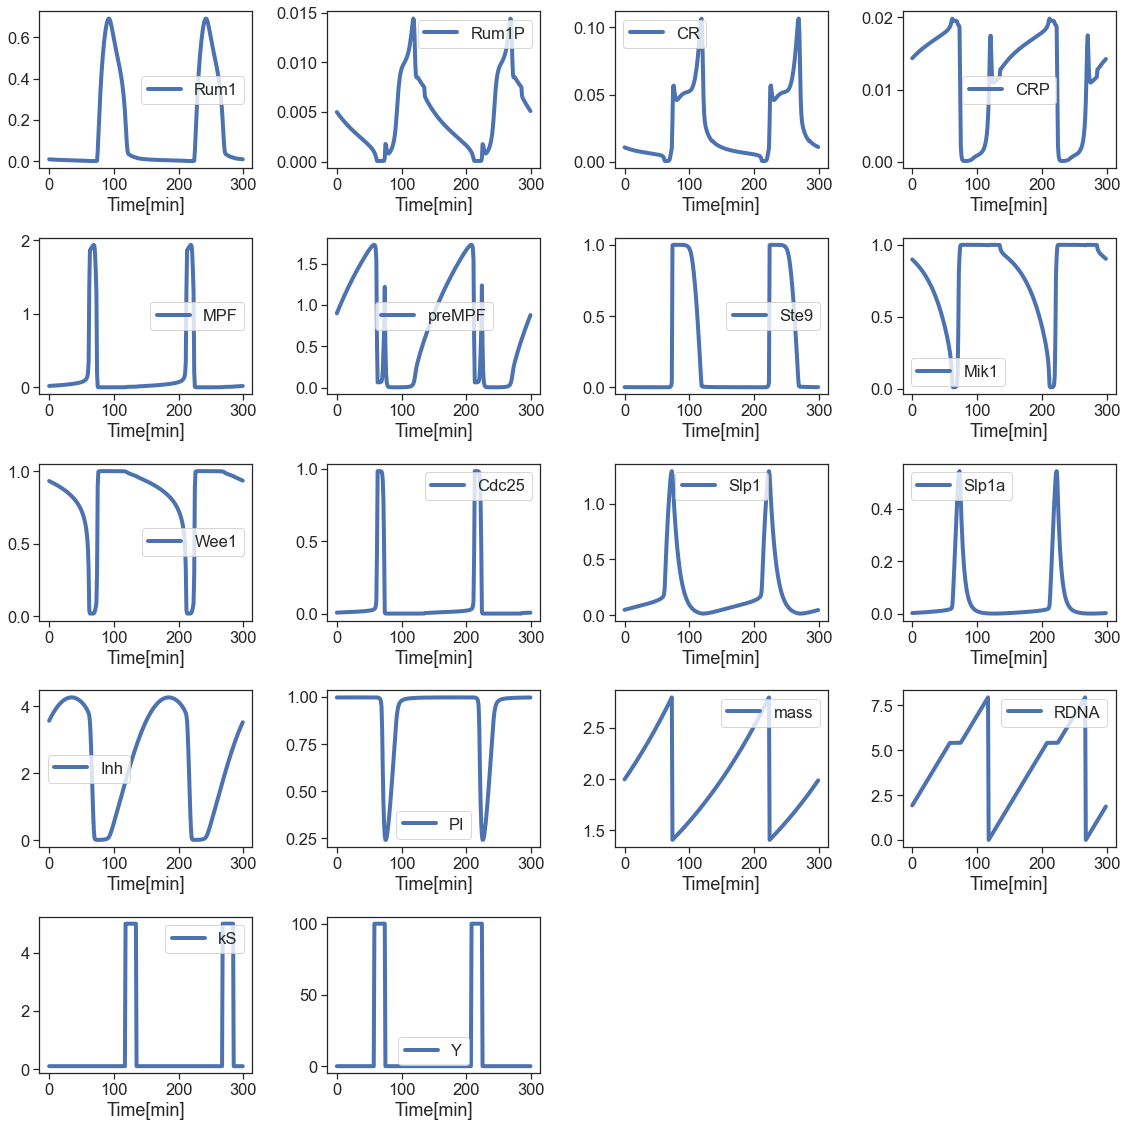

In [5]:
# Plotting result

plotStartTime = 1500
plotEndTime = 1800

labelvec =['Rum1','Rum1P','CR','CRP','MPF',
           'preMPF','Ste9','Mik1','Wee1','Cdc25',
          'Slp1','Slp1a','Inh','PI','mass',
          'RDNA', 'kS', 'Y']

plt.figure(figsize=(16,16))

for i in range(len(xinit)):
    plt.subplot(5,4,i+1)
    plt.plot(time_points[plotStartTime:plotEndTime]-plotStartTime, xvec[plotStartTime:plotEndTime,i], label=labelvec[i])
    plt.legend()
    plt.xlabel('Time[min]')
    plt.tight_layout()

plt.show()

meta NOT subset; don't know how to subset; dropped


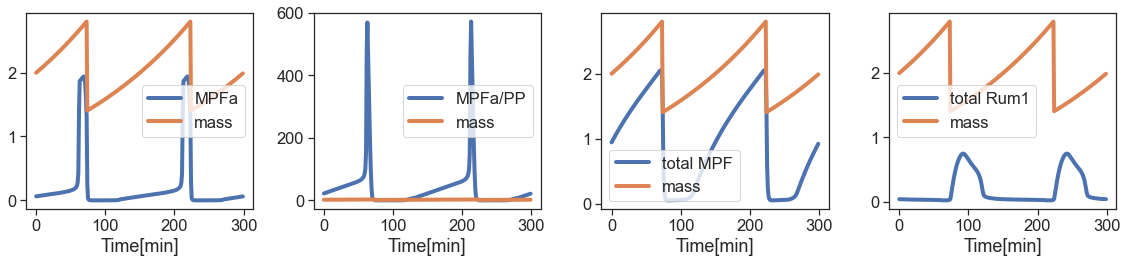

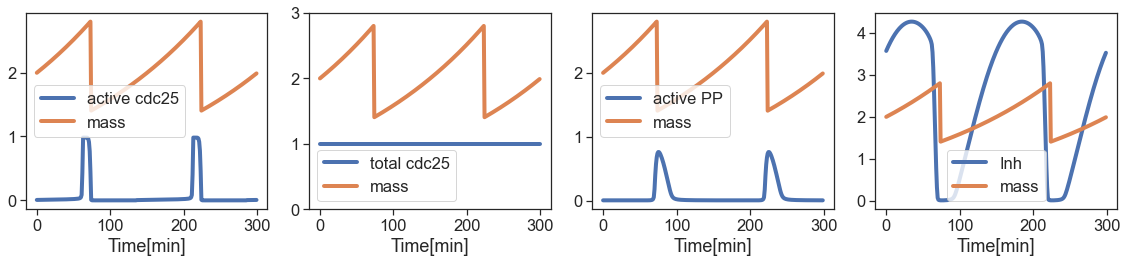

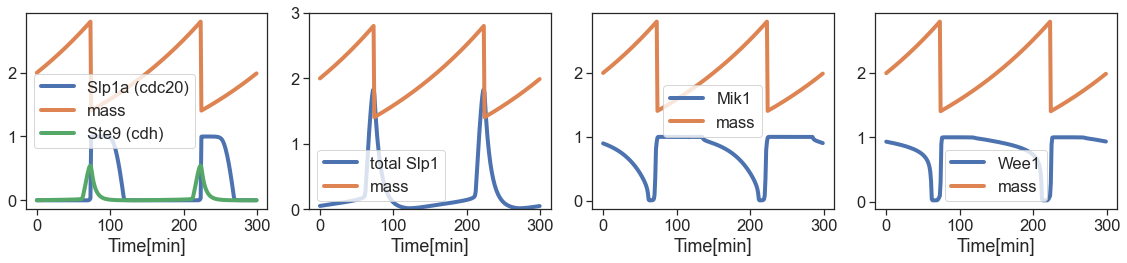

In [10]:

# plot 1: MPFa, active cdc2/cdc13 atitivity
plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
epsi = 0.05
plt.plot(time_points[plotStartTime:plotEndTime]-plotStartTime, 
         xvec[plotStartTime:plotEndTime,4]+epsi*xvec[plotStartTime:plotEndTime,5], label = 'MPFa')
plt.plot(time_points[plotStartTime:plotEndTime]-plotStartTime, 
         xvec[plotStartTime:plotEndTime,14], label = 'mass')
plt.legend()
plt.xlabel('Time[min]')

# plot 2: MPFa/PP
plt.subplot(1,4,2)
plt.plot(time_points[plotStartTime:plotEndTime]-plotStartTime,         
         (xvec[plotStartTime:plotEndTime,4]+epsi*xvec[plotStartTime:plotEndTime,5])/(1-xvec[plotStartTime:plotEndTime,13]), label = 'MPFa/PP')
plt.plot(time_points[plotStartTime:plotEndTime]-plotStartTime, 
         xvec[plotStartTime:plotEndTime,14], label = 'mass')
plt.legend()
plt.xlabel('Time[min]')
plt.tight_layout()

# plot 3: Total cdc13
plt.subplot(1,4,3)
plt.plot(time_points[plotStartTime:plotEndTime]-plotStartTime, 
         np.sum(xvec[plotStartTime:plotEndTime,2:6],axis=1), label = 'total MPF')
plt.plot(time_points[plotStartTime:plotEndTime]-plotStartTime, 
         xvec[plotStartTime:plotEndTime,14], label = 'mass')
plt.legend()
plt.xlabel('Time[min]')
plt.tight_layout()

# plot 4: total Rum1
plt.subplot(1,4,4)
plt.plot(time_points[plotStartTime:plotEndTime]-plotStartTime, 
         np.sum(xvec[plotStartTime:plotEndTime,0:4],axis=1), label = 'total Rum1')
plt.plot(time_points[plotStartTime:plotEndTime]-plotStartTime, 
         xvec[plotStartTime:plotEndTime,14], label = 'mass')
plt.legend()
plt.xlabel('Time[min]')
plt.tight_layout()

plt.savefig("./_MPFactivity.png")
plt.savefig("./_MPFactivity.pdf")

#=====================================================
# plot 5: Active cdc25 (p-Cdc25)
plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
epsi = 0.05
plt.plot(time_points[plotStartTime:plotEndTime]-plotStartTime, 
         xvec[plotStartTime:plotEndTime,9], label = 'active cdc25')
plt.plot(time_points[plotStartTime:plotEndTime]-plotStartTime, 
         xvec[plotStartTime:plotEndTime,14], label = 'mass')
plt.legend()
plt.xlabel('Time[min]')

# plot 6: Total Cdc25
plt.subplot(1,4,2)
plt.plot(time_points[plotStartTime:plotEndTime]-plotStartTime, 
         np.zeros((plotEndTime-plotStartTime,1))+1, label = 'total cdc25')
plt.plot(time_points[plotStartTime:plotEndTime]-plotStartTime, 
         xvec[plotStartTime:plotEndTime,14], label = 'mass')
plt.legend()
plt.xlabel('Time[min]')
plt.ylim([0,3])
plt.tight_layout()

# plot 7: active Phosphatase
plt.subplot(1,4,3)
plt.plot(time_points[plotStartTime:plotEndTime]-plotStartTime, 
         (1-xvec[plotStartTime:plotEndTime,13]), label = 'active PP')
plt.plot(time_points[plotStartTime:plotEndTime]-plotStartTime, 
         xvec[plotStartTime:plotEndTime,14], label = 'mass')
plt.legend()
plt.xlabel('Time[min]')
plt.tight_layout()

# plot 8: Phosphatase inhibitor
plt.subplot(1,4,4)
plt.plot(time_points[plotStartTime:plotEndTime]-plotStartTime, 
         xvec[plotStartTime:plotEndTime,12], label = 'Inh')
plt.plot(time_points[plotStartTime:plotEndTime]-plotStartTime, 
         xvec[plotStartTime:plotEndTime,14], label = 'mass')
plt.legend()
plt.xlabel('Time[min]')
plt.tight_layout()

#=====================================================
# plot 9: Active Slp1 (cdc20) and Ste9
plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
epsi = 0.05
plt.plot(time_points[plotStartTime:plotEndTime]-plotStartTime, 
         xvec[plotStartTime:plotEndTime,6], label = 'Slp1a (cdc20)')
plt.plot(time_points[plotStartTime:plotEndTime]-plotStartTime, 
         xvec[plotStartTime:plotEndTime,14], label = 'mass')
plt.plot(time_points[plotStartTime:plotEndTime]-plotStartTime, 
         xvec[plotStartTime:plotEndTime,11], label = 'Ste9 (cdh)')
plt.legend()
plt.xlabel('Time[min]')

# plot 10: Total Slp1 
plt.subplot(1,4,2)
plt.plot(time_points[plotStartTime:plotEndTime]-plotStartTime, 
         xvec[plotStartTime:plotEndTime,10]+xvec[plotStartTime:plotEndTime,11], label = 'total Slp1')
plt.plot(time_points[plotStartTime:plotEndTime]-plotStartTime, 
         xvec[plotStartTime:plotEndTime,14], label = 'mass')
plt.legend()
plt.xlabel('Time[min]')
plt.ylim([0,3])
plt.tight_layout()

# plot 11: Mik1
plt.subplot(1,4,3)
plt.plot(time_points[plotStartTime:plotEndTime]-plotStartTime, 
         (xvec[plotStartTime:plotEndTime,7]), label = 'Mik1')
plt.plot(time_points[plotStartTime:plotEndTime]-plotStartTime, 
         xvec[plotStartTime:plotEndTime,14], label = 'mass')
plt.legend()
plt.xlabel('Time[min]')
plt.tight_layout()

# plot 12: Wee1
plt.subplot(1,4,4)
plt.plot(time_points[plotStartTime:plotEndTime]-plotStartTime, 
         xvec[plotStartTime:plotEndTime,8], label = 'Wee1')
plt.plot(time_points[plotStartTime:plotEndTime]-plotStartTime, 
         xvec[plotStartTime:plotEndTime,14], label = 'mass')
plt.legend()
plt.xlabel('Time[min]')
plt.tight_layout()
